In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path_to_folder = r'D:\Work\Kaggle\house-prices-advanced-regression-techniques'


train_df = pd.read_csv(path_to_folder + r'\train.csv')
X_test = pd.read_csv(path_to_folder + r'\test.csv')
X_train = train_df #.iloc[:,:-1]

#drop columns
X_train.drop(['Id', 'SaleType'], inplace=True, axis=1)
X_test.drop(['Id', 'SaleType'], inplace=True, axis=1)

(2917, 78)

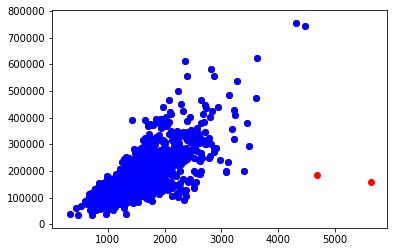

In [31]:
#PLOT DATA
#plt.scatter(X_train['GrLivArea'],X_train['SalePrice'])
#remove outlier
plt.scatter(X_train['GrLivArea'],X_train['SalePrice'], c='red') # outliers marked in red
X_train = X_train.drop(X_train[(X_train['GrLivArea'] > 4000) & (X_train['SalePrice'] < 200000)].index)
X_train.shape
plt.scatter(X_train['GrLivArea'],X_train['SalePrice'], c='blue')
#plt.hist(X_train['SalePrice'])
X_train['SalePrice'] = np.log1p(X_train['SalePrice'])
y_train = X_train['SalePrice']
X_train.drop(['SalePrice'], inplace=True, axis=1)
X_train.shape

#Combine Train Test
combine_df = pd.concat([X_train, X_test])
combine_df.shape

In [32]:
#MISSING VALUE TREATMENT
missing_values_nc_cols = ['GarageCond', 'GarageType', 'GarageQual', 'GarageFinish', 'Alley','Fence', 'PoolQC',
                           'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MiscFeature',
                           'FireplaceQu', 'MasVnrType']
missing_values_cont_cols = ['MasVnrArea', 'LotFrontage', 'GarageYrBlt']

for colname in missing_values_nc_cols:
    combine_df[colname].fillna('None', inplace=True)
    combine_df[colname].fillna('None', inplace=True)

for colname in missing_values_cont_cols:
    combine_df[colname].fillna(combine_df[colname].median(), inplace=True)
    combine_df[colname].fillna(combine_df[colname].median(), inplace=True)

combine_df['Electrical'].fillna(str(combine_df['Electrical'].mode()[0]), inplace=True)
combine_df['MSZoning'].fillna(str(combine_df['MSZoning'].mode()[0]), inplace=True)
combine_df['Utilities'].fillna(str(combine_df['Utilities'].mode()[0]), inplace=True)
combine_df['BsmtFullBath'].fillna(int(combine_df['BsmtFullBath'].min()), inplace=True)
combine_df['BsmtHalfBath'].fillna(int(combine_df['BsmtHalfBath'].min()), inplace=True)
combine_df['BsmtFinSF1'].fillna(int(combine_df['BsmtFinSF1'].min()), inplace=True)
combine_df['BsmtFinSF2'].fillna(int(combine_df['BsmtFinSF2'].min()), inplace=True)
combine_df['BsmtUnfSF'].fillna(int(combine_df['BsmtUnfSF'].min()), inplace=True)
combine_df['TotalBsmtSF'].fillna(int(combine_df['TotalBsmtSF'].min()), inplace=True)
combine_df['Exterior1st'].fillna(str(combine_df['Exterior1st'].mode()[0]), inplace=True)
combine_df['Exterior2nd'].fillna(str(combine_df['Exterior1st'].mode()[0]), inplace=True) #not a typo
combine_df['Functional'].fillna(str(combine_df['Functional'].mode()[0]), inplace=True)
combine_df['KitchenQual'].fillna(str(combine_df['KitchenQual'].mode()[0]), inplace=True)
combine_df['GarageCars'].fillna(int(combine_df['GarageCars'].min()), inplace=True)
combine_df['GarageArea'].fillna(int(combine_df['GarageArea'].min()), inplace=True)
#combine_df['SaleType'].fillna(str(combine_df['SaleType'].mode()[0]), inplace=True)

In [33]:
#Data Analysis and Transformation
#create a new column which contains the total area of the house
combine_df['TotalHouseArea'] = combine_df['TotalBsmtSF'] + combine_df['1stFlrSF'] + combine_df['2ndFlrSF']
combine_df.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], inplace=True, axis=1)

combine_df['MSSubClass'] = combine_df['MSSubClass'].astype(str)
combine_df['OverallCond'] = combine_df['OverallCond'].astype(str)
combine_df['GarageYrBlt'] = combine_df['GarageYrBlt'].astype(str)

combine_df['MoSold'] = combine_df['MoSold'].astype(str)
combine_df['YrSold'] = combine_df['YrSold'].astype(str)

from scipy import stats
from scipy.stats import norm, skew #for some statistics
numeric_feats = combine_df.dtypes[combine_df.dtypes != "object"].index
skewed_feats = combine_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skd_df = pd.DataFrame({'skewval':skewed_feats})

#get all features with skewness greater than 0.75
skd_df = skd_df[abs(skd_df) > 0.75]
from scipy.special import boxcox1p
skewed_feat = skd_df.index
lam = 0.15
for feat in skewed_feat:
    #all_data[feat] += 1
    combine_df[feat] = boxcox1p(combine_df[feat], lam)

combine_df = pd.get_dummies(combine_df)
combine_df.shape

X_train = combine_df.iloc[0:1458,:].values
X_test = combine_df.iloc[1458:,:].values
y_train = y_train.values

## Modeling

In [60]:
#Import models
from sklearn.linear_model import LinearRegression, Lasso, RidgeCV, ElasticNet, BayesianRidge, LassoLars
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score


#Validation function
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return rmse

In [69]:
#Linear Models
lmlist = [LinearRegression(), Lasso(), RidgeCV(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3), BayesianRidge(), LassoLars()]
for m in mlist:
    score = rmsle_cv(m)
    #.fit(X_train, y_train)
    #core = m.score(X_train, y_train)
    print(score.mean())

185288876.49480337
0.3994682097577765
0.12327998154020312
0.3769456866311338
0.11635469234753167
0.3994682097577765


In [53]:
dtreg = DecisionTreeRegressor()
dtregscore = rmsle_cv(reg)
print(dtregscore.mean())

0.20046844771716654


In [55]:
rfreg = RandomForestRegressor()
rfscore = rmsle_cv(rfreg)
print(rfscore.mean())

0.13976626337095524


In [68]:
xgreg = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
xgscore = rmsle_cv(xgreg)
print(xgscore.mean())

0.11768249459661448


In [67]:
lgbreg = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
lgbscore = rmsle_cv(lgbreg)
print(lgbscore.mean())

0.11657739862681257


In [83]:
estimators = [('br',BayesianRidge()),('lgr',lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)),
              ('xgr',xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1))]
stackreg = StackingRegressor(estimators = estimators, final_estimator=BayesianRidge())
score = rmsle_cv(stackreg)
score.mean()

In [66]:
xgreg.fit(X_train, y_train)
x = xgreg.predict(X_train, y_train)

[04:16:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [72]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [84]:
stackreg.fit(X_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('br',
                               BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                             alpha_init=None,
                                             compute_score=False, copy_X=True,
                                             fit_intercept=True, lambda_1=1e-06,
                                             lambda_2=1e-06, lambda_init=None,
                                             n_iter=300, normalize=False,
                                             tol=0.001, verbose=False)),
                              ('lgr',
                               LGBMRegressor(bagging_fraction=0.8,
                                             bagging_freq=5, bagging_seed=9,
                                             boosting_type='gbdt',
                                             clas...
                                            reg_lambda=0.8571,
                                            scal

In [87]:
predictions = np.expm1(stackreg.predict(X_test))
predictions

array([125822.66, 161735.83, 184760.75, ..., 163939.9 , 117117.7 ,
       220205.6 ], dtype=float32)

In [88]:

sample_df = pd.read_csv(path_to_folder + r'\sample_submission.csv')
sample_df['SalePrice'] = predictions
sample_df.to_csv(path_to_folder + r'/Predictions/' + 'Results_stacking_2.csv', index=False)